In [11]:
from F4 import PNL_per_day, DumpCSV_and_MesToTele, position_input, position_report, BacktestInformation
import pandas as pd
import datetime
import numpy as np
import time
import requests
from time import sleep
from ta.momentum import AwesomeOscillatorIndicator
from ta.trend import MACD, CCIIndicator, EMAIndicator, ADXIndicator
from ta.volatility import BollingerBands
from ta.volume import ChaikinMoneyFlowIndicator
import warnings
warnings.filterwarnings('ignore')
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True, connected=True)

In [12]:
data = pd.read_csv('.\data1mins.csv')

In [13]:
data

Loading ITables v2.5.2 from the internet... (need help?)


In [14]:
data.Date = pd.to_datetime(data.Date, errors = 'coerce')
data = data.set_index("Date")
data = data.resample('10Min').agg({'Open': 'first', 'Close': 'last', 'High': 'max', 'Low': 'min', 'Volume': 'sum'}).dropna()
data = data.reset_index()

In [15]:
from scipy import signal
from scipy.signal import butter,lfilter 

def lowpass_filter_period_only(x, cutoff_period: int = 20, order: int = 2, zero_phase: bool = False):
    cutoff_period = max(int(cutoff_period), 3)  # kẹp tối thiểu 3
    Wn = 2.0 / float(cutoff_period)
    Wn = min(max(Wn, 1e-6), 0.999999)          # đảm bảo (0,1)
    sos = butter(order, Wn, btype="low", output="sos")
    if zero_phase:
        y = signal.sosfiltfilt(sos, pd.Series(x).values, method="gust")
    else:
        y = signal.sosfilt(sos, pd.Series(x).values)
    return pd.Series(y, index=pd.Series(x).index)


In [16]:
df = pd.read_csv('.\expiration_date.csv')
df.Date = pd.to_datetime(df['Date'])
expiration_date = set(map(lambda x: x.date(), df['Date']))
expiration_date

{datetime.date(2124, 2, 17),
 datetime.date(2178, 12, 17),
 datetime.date(2180, 2, 17),
 datetime.date(2166, 11, 20),
 datetime.date(2027, 8, 19),
 datetime.date(2068, 2, 16),
 datetime.date(2069, 6, 20),
 datetime.date(2082, 12, 17),
 datetime.date(2249, 11, 15),
 datetime.date(2141, 1, 19),
 datetime.date(2172, 1, 16),
 datetime.date(2019, 10, 17),
 datetime.date(2079, 11, 16),
 datetime.date(2110, 5, 15),
 datetime.date(2181, 10, 18),
 datetime.date(2067, 10, 20),
 datetime.date(2257, 9, 17),
 datetime.date(2135, 9, 15),
 datetime.date(2029, 7, 19),
 datetime.date(2232, 9, 20),
 datetime.date(2245, 1, 16),
 datetime.date(2223, 2, 20),
 datetime.date(2086, 8, 15),
 datetime.date(2201, 6, 18),
 datetime.date(2035, 8, 16),
 datetime.date(2124, 12, 21),
 datetime.date(2148, 12, 19),
 datetime.date(2020, 2, 20),
 datetime.date(2105, 1, 15),
 datetime.date(2217, 12, 18),
 datetime.date(2130, 9, 21),
 datetime.date(2190, 12, 16),
 datetime.date(2226, 2, 16),
 datetime.date(2149, 2, 20),
 d

In [19]:
import pandas as pd
import numpy as np
from ta.trend import CCIIndicator, ADXIndicator
import datetime

def alpha(data, params):
    
    data = data.copy()
    
    data['CCI'] = CCIIndicator(high=data['High'], low=data['Low'], close=data['Close'], window=params['cci_win']).cci()
    
    data['ADX'] = ADXIndicator(high=data['High'], low=data['Low'], close=data['Close'], 
                              window=params['adx_win']).adx().fillna(20)
    
    pos = 0
    position = []
    # Warmup period to avoid NaN
    warmup = max(params['cci_win'], params['adx_win'])
    
    for i in range(len(data)):
        # Skip warmup period or invalid data
        if i < warmup or np.isnan(data['CCI'].iat[i]) or np.isnan(data['ADX'].iat[i]):
            position.append(0)
            continue
        
        CCI = data['CCI'].iat[i]
        adx = data['ADX'].iat[i]
        is_sideways = adx < params.get('adx_threshold', params['adx_threshold'])
        
        if pos == 0:
            # Entry short: CCI oversold + not sideways
            if CCI < params['t2'] and not is_sideways:
                pos = -1
            # Entry long: CCI overbought + not sideways
            elif CCI > params['t3'] and not is_sideways:
                pos = 1
        elif pos == -1:
            # Exit short: CCI neutral or market turns sideways
            if CCI > params['t4'] or is_sideways:
                pos = 0
        elif pos == 1:
            # Exit long: CCI neutral or market turns sideways
            if CCI < params['t5'] or is_sideways:
                pos = 0
                
        # End-of-day exit for short
        current_time = data['Date'].iloc[i].time()
        current_date = data['Date'].iloc[i].date()
        expiration_date = params.get('expiration_date', [])
        
        if current_time == datetime.time(14, 25) and pos == -1:
            pos = 0
        if current_time == datetime.time(14, 45) and current_date in expiration_date:
            pos = 0
        
        position.append(pos)
    
    data['pos'] = position
    return data

In [20]:
import optuna
# === Metric & Backtest ===
def compute_metrics(df, price_col='Close', pos_col='pos', slip_bps=1.0, fee_bps=1.0):
    df = df.copy()
    ret = df[price_col].pct_change().fillna(0.0)
    pos = df[pos_col].fillna(0.0)
    pos_shift = pos.shift(1).fillna(0.0)
    strat_ret = ret * pos_shift
    delta_pos = pos.diff().abs().fillna(0.0)
    trade_cost = (slip_bps + fee_bps) / 10000.0
    cost = delta_pos * trade_cost
    strat_ret = strat_ret - cost
    
    if 'Date' in df.columns:
        day = pd.to_datetime(df['Date']).dt.date
        daily_ret = strat_ret.groupby(day).sum()
    else:
        daily_ret = strat_ret
    
    mean = daily_ret.mean()
    std = daily_ret.std(ddof=1)
    sharpe = 0.0 if std == 0 else (mean / std) * np.sqrt(252)
    
    eq = (1 + daily_ret).cumprod()
    dd = (eq.cummax() - eq) / eq.cummax()
    mdd = dd.max() if len(dd) else 0.0
    
    trades = int((delta_pos > 0).sum())
    
    return {'sharpe': float(sharpe), 'mdd': float(mdd), 'trades': trades}

# === Objective for Optuna ===
def make_objective(data, base_params=None):
    base_params = dict(base_params or {})
    
    def objective(trial: optuna.Trial):
        # Search space (all integers)
        w1 = trial.suggest_int('w1', 10, 30)  # CCI window
        cci_win = trial.suggest_int('cci_win', 10, 30)  # CCI window
        t2 = trial.suggest_int('t2', 5, 40)   # CCI threshold to enter short
        t3 = trial.suggest_int('t3', 60, 95)  # CCI threshold to enter long
        t4 = trial.suggest_int('t4', t2 + 1, 85)  # CCI threshold to exit short (ensure t4 > t2)
        t5 = trial.suggest_int('t5', 15, t3 - 1)  # CCI threshold to exit long (ensure t5 < t3)
        adx_win = trial.suggest_int('adx_win', 10, 30)
        adx_threshold = trial.suggest_int('adx_threshold', 10, 50)
        
        
        # Parameters for alpha
        params = {
            't1': base_params.get('t1', 0.75),  # Keep t1 as float if required by lowpass filter
            'w1': w1,
            't2': t2, 't3': t3, 't4': t4, 't5': t5,
            'cci_win': cci_win,
            'adx_win': adx_win,
            'adx_threshold': adx_threshold
        }
        
        # Run alpha function
        df_pos = alpha(data, params)
        
        # Calculate metrics
        metrics = compute_metrics(df_pos, slip_bps=1.0, fee_bps=1.0)
        score = metrics['sharpe']
        
        # Penalty for low trades
        if metrics['trades'] < 5:
            score -= 0.5
        
        # Optional: Penalize high drawdown
        # score -= 0.5 * metrics['mdd']
        
        trial.report(score, step=0)
        return score
    
    return objective

# === Run Study ===
sampler = optuna.samplers.TPESampler(seed=42, multivariate=True, group=True)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)

study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)
base_params = {'t1': 0.75, 't2': 31, 't3': 95, 't4': 84, 't5': 58, 'w1': 15, 'cci_win': 25, 'adx_win':14, 'adx_threshold': 25}
study.optimize(make_objective(data, base_params=base_params),
               n_trials=200, show_progress_bar=True)

print("Best Sharpe:", study.best_value)
print("Best params:", study.best_params)

# Backtest with best parameters
best_params = base_params.copy()
best_params.update(study.best_params)
df_best = alpha(data, best_params)
final = compute_metrics(df_best)
print("Final metrics:", final)

[I 2025-09-18 16:27:48,256] A new study created in memory with name: no-name-93217f00-b52d-4865-ab55-9876765f753b
Best trial: 0. Best value: 0.868888:   0%|          | 1/200 [00:05<18:33,  5.59s/it]

[I 2025-09-18 16:27:53,849] Trial 0 finished with value: 0.8688881247866069 and parameters: {'w1': 17, 'cci_win': 29, 't2': 31, 't3': 81, 't4': 40, 't5': 25, 'adx_win': 11, 'adx_threshold': 45}. Best is trial 0 with value: 0.8688881247866069.


Best trial: 1. Best value: 1.39562:   1%|          | 2/200 [00:11<18:36,  5.64s/it] 

[I 2025-09-18 16:27:59,518] Trial 1 finished with value: 1.3956245052151723 and parameters: {'w1': 22, 'cci_win': 24, 't2': 5, 't3': 94, 't4': 72, 't5': 31, 'adx_win': 13, 'adx_threshold': 17}. Best is trial 1 with value: 1.3956245052151723.


Best trial: 1. Best value: 1.39562:   2%|▏         | 3/200 [00:16<18:28,  5.63s/it]

[I 2025-09-18 16:28:05,132] Trial 2 finished with value: 0.8493144815469124 and parameters: {'w1': 16, 'cci_win': 21, 't2': 20, 't3': 70, 't4': 60, 't5': 22, 'adx_win': 16, 'adx_threshold': 25}. Best is trial 1 with value: 1.3956245052151723.


Best trial: 1. Best value: 1.39562:   2%|▏         | 4/200 [00:22<18:22,  5.62s/it]

[I 2025-09-18 16:28:10,751] Trial 3 finished with value: 0.9692401191496576 and parameters: {'w1': 19, 'cci_win': 26, 't2': 12, 't3': 78, 't4': 56, 't5': 17, 'adx_win': 22, 'adx_threshold': 16}. Best is trial 1 with value: 1.3956245052151723.


Best trial: 1. Best value: 1.39562:   2%|▎         | 5/200 [00:27<18:02,  5.55s/it]

[I 2025-09-18 16:28:16,178] Trial 4 finished with value: 0.05948105557968619 and parameters: {'w1': 11, 'cci_win': 29, 't2': 39, 't3': 89, 't4': 54, 't5': 22, 'adx_win': 24, 'adx_threshold': 28}. Best is trial 1 with value: 1.3956245052151723.


Best trial: 1. Best value: 1.39562:   3%|▎         | 6/200 [00:33<17:55,  5.54s/it]

[I 2025-09-18 16:28:21,698] Trial 5 finished with value: 0.37739596076353193 and parameters: {'w1': 12, 'cci_win': 20, 't2': 6, 't3': 92, 't4': 27, 't5': 66, 'adx_win': 16, 'adx_threshold': 31}. Best is trial 1 with value: 1.3956245052151723.


Best trial: 1. Best value: 1.39562:   4%|▎         | 7/200 [00:38<17:45,  5.52s/it]

[I 2025-09-18 16:28:27,177] Trial 6 finished with value: -0.014785165744002949 and parameters: {'w1': 21, 'cci_win': 13, 't2': 39, 't3': 87, 't4': 83, 't5': 79, 'adx_win': 22, 'adx_threshold': 47}. Best is trial 1 with value: 1.3956245052151723.


Best trial: 1. Best value: 1.39562:   4%|▍         | 8/200 [00:44<17:43,  5.54s/it]

[I 2025-09-18 16:28:32,749] Trial 7 finished with value: 0.30256654234388874 and parameters: {'w1': 11, 'cci_win': 14, 't2': 6, 't3': 71, 't4': 37, 't5': 30, 'adx_win': 27, 'adx_threshold': 24}. Best is trial 1 with value: 1.3956245052151723.


Best trial: 1. Best value: 1.39562:   4%|▍         | 9/200 [00:49<17:30,  5.50s/it]

[I 2025-09-18 16:28:38,168] Trial 8 finished with value: 0.4569309334937596 and parameters: {'w1': 15, 'cci_win': 21, 't2': 10, 't3': 88, 't4': 16, 't5': 87, 'adx_win': 26, 'adx_threshold': 18}. Best is trial 1 with value: 1.3956245052151723.


Best trial: 1. Best value: 1.39562:   5%|▌         | 10/200 [00:55<17:27,  5.52s/it]

[I 2025-09-18 16:28:43,717] Trial 9 finished with value: 1.3578206114681746 and parameters: {'w1': 10, 'cci_win': 27, 't2': 30, 't3': 86, 't4': 73, 't5': 20, 'adx_win': 17, 'adx_threshold': 14}. Best is trial 1 with value: 1.3956245052151723.


Best trial: 1. Best value: 1.39562:   6%|▌         | 11/200 [01:00<17:23,  5.52s/it]

[I 2025-09-18 16:28:49,248] Trial 10 finished with value: 0.9244693249614848 and parameters: {'w1': 28, 'cci_win': 20, 't2': 9, 't3': 92, 't4': 82, 't5': 44, 'adx_win': 17, 'adx_threshold': 25}. Best is trial 1 with value: 1.3956245052151723.


Best trial: 11. Best value: 1.47416:   6%|▌         | 12/200 [01:06<17:21,  5.54s/it]

[I 2025-09-18 16:28:54,832] Trial 11 finished with value: 1.4741619565010669 and parameters: {'w1': 11, 'cci_win': 25, 't2': 15, 't3': 94, 't4': 74, 't5': 25, 'adx_win': 17, 'adx_threshold': 12}. Best is trial 11 with value: 1.4741619565010669.


Best trial: 11. Best value: 1.47416:   6%|▋         | 13/200 [01:12<17:22,  5.57s/it]

[I 2025-09-18 16:29:00,488] Trial 12 finished with value: 1.3204686756420334 and parameters: {'w1': 21, 'cci_win': 29, 't2': 17, 't3': 94, 't4': 69, 't5': 23, 'adx_win': 14, 'adx_threshold': 11}. Best is trial 11 with value: 1.4741619565010669.


Best trial: 11. Best value: 1.47416:   7%|▋         | 14/200 [01:17<17:18,  5.59s/it]

[I 2025-09-18 16:29:06,098] Trial 13 finished with value: 1.4111182002106373 and parameters: {'w1': 10, 'cci_win': 19, 't2': 9, 't3': 92, 't4': 73, 't5': 26, 'adx_win': 15, 'adx_threshold': 12}. Best is trial 11 with value: 1.4741619565010669.


Best trial: 14. Best value: 1.54616:   8%|▊         | 15/200 [01:23<17:08,  5.56s/it]

[I 2025-09-18 16:29:11,598] Trial 14 finished with value: 1.5461555518269217 and parameters: {'w1': 12, 'cci_win': 20, 't2': 8, 't3': 80, 't4': 64, 't5': 35, 'adx_win': 10, 'adx_threshold': 10}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:   8%|▊         | 16/200 [01:28<16:59,  5.54s/it]

[I 2025-09-18 16:29:17,091] Trial 15 finished with value: 1.4316014523007126 and parameters: {'w1': 10, 'cci_win': 26, 't2': 8, 't3': 74, 't4': 74, 't5': 34, 'adx_win': 14, 'adx_threshold': 12}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:   8%|▊         | 17/200 [01:34<17:00,  5.58s/it]

[I 2025-09-18 16:29:22,758] Trial 16 finished with value: 1.3842756715460178 and parameters: {'w1': 14, 'cci_win': 15, 't2': 6, 't3': 64, 't4': 68, 't5': 15, 'adx_win': 14, 'adx_threshold': 10}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:   9%|▉         | 18/200 [01:40<16:58,  5.59s/it]

[I 2025-09-18 16:29:28,388] Trial 17 finished with value: 0.6723090553057152 and parameters: {'w1': 11, 'cci_win': 26, 't2': 13, 't3': 95, 't4': 83, 't5': 51, 'adx_win': 20, 'adx_threshold': 19}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  10%|▉         | 19/200 [01:45<16:53,  5.60s/it]

[I 2025-09-18 16:29:34,003] Trial 18 finished with value: 1.3787741372674052 and parameters: {'w1': 21, 'cci_win': 15, 't2': 9, 't3': 87, 't4': 41, 't5': 36, 'adx_win': 11, 'adx_threshold': 16}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  10%|█         | 20/200 [01:51<16:41,  5.56s/it]

[I 2025-09-18 16:29:39,479] Trial 19 finished with value: 1.196244524349958 and parameters: {'w1': 14, 'cci_win': 17, 't2': 7, 't3': 74, 't4': 79, 't5': 70, 'adx_win': 11, 'adx_threshold': 12}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  10%|█         | 21/200 [01:56<16:34,  5.56s/it]

[I 2025-09-18 16:29:45,027] Trial 20 finished with value: 0.6077006044947377 and parameters: {'w1': 13, 'cci_win': 28, 't2': 16, 't3': 90, 't4': 84, 't5': 15, 'adx_win': 15, 'adx_threshold': 29}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  11%|█         | 22/200 [02:02<16:25,  5.54s/it]

[I 2025-09-18 16:29:50,508] Trial 21 finished with value: 1.2593734209466558 and parameters: {'w1': 10, 'cci_win': 30, 't2': 10, 't3': 81, 't4': 67, 't5': 36, 'adx_win': 14, 'adx_threshold': 16}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  12%|█▏        | 23/200 [02:07<16:22,  5.55s/it]

[I 2025-09-18 16:29:56,097] Trial 22 finished with value: 1.4033727171564523 and parameters: {'w1': 16, 'cci_win': 26, 't2': 11, 't3': 71, 't4': 85, 't5': 23, 'adx_win': 13, 'adx_threshold': 14}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  12%|█▏        | 24/200 [02:13<16:14,  5.54s/it]

[I 2025-09-18 16:30:01,607] Trial 23 finished with value: 1.3153079189523182 and parameters: {'w1': 11, 'cci_win': 24, 't2': 25, 't3': 78, 't4': 52, 't5': 50, 'adx_win': 12, 'adx_threshold': 16}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  12%|█▎        | 25/200 [02:18<16:06,  5.52s/it]

[I 2025-09-18 16:30:07,092] Trial 24 finished with value: 1.4018065481811022 and parameters: {'w1': 10, 'cci_win': 15, 't2': 8, 't3': 77, 't4': 61, 't5': 31, 'adx_win': 11, 'adx_threshold': 12}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  13%|█▎        | 26/200 [02:24<16:05,  5.55s/it]

[I 2025-09-18 16:30:12,697] Trial 25 finished with value: 1.2891224775405112 and parameters: {'w1': 14, 'cci_win': 22, 't2': 12, 't3': 78, 't4': 65, 't5': 32, 'adx_win': 10, 'adx_threshold': 16}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  14%|█▎        | 27/200 [02:30<16:00,  5.55s/it]

[I 2025-09-18 16:30:18,255] Trial 26 finished with value: 1.4501076000190578 and parameters: {'w1': 10, 'cci_win': 22, 't2': 6, 't3': 72, 't4': 80, 't5': 44, 'adx_win': 13, 'adx_threshold': 14}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  14%|█▍        | 28/200 [02:35<15:51,  5.53s/it]

[I 2025-09-18 16:30:23,744] Trial 27 finished with value: 0.07729772321890575 and parameters: {'w1': 12, 'cci_win': 24, 't2': 11, 't3': 61, 't4': 82, 't5': 43, 'adx_win': 20, 'adx_threshold': 28}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  14%|█▍        | 29/200 [02:40<15:42,  5.51s/it]

[I 2025-09-18 16:30:29,210] Trial 28 finished with value: 0.8064864244755943 and parameters: {'w1': 11, 'cci_win': 13, 't2': 8, 't3': 76, 't4': 85, 't5': 37, 'adx_win': 17, 'adx_threshold': 21}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  15%|█▌        | 30/200 [02:46<15:36,  5.51s/it]

[I 2025-09-18 16:30:34,711] Trial 29 finished with value: 1.3402058611130787 and parameters: {'w1': 16, 'cci_win': 24, 't2': 10, 't3': 71, 't4': 75, 't5': 55, 'adx_win': 11, 'adx_threshold': 20}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  16%|█▌        | 31/200 [02:52<15:32,  5.52s/it]

[I 2025-09-18 16:30:40,255] Trial 30 finished with value: 1.489839206046479 and parameters: {'w1': 10, 'cci_win': 23, 't2': 9, 't3': 80, 't4': 79, 't5': 54, 'adx_win': 11, 'adx_threshold': 18}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  16%|█▌        | 32/200 [02:57<15:25,  5.51s/it]

[I 2025-09-18 16:30:45,732] Trial 31 finished with value: 1.045393362112261 and parameters: {'w1': 10, 'cci_win': 25, 't2': 14, 't3': 83, 't4': 76, 't5': 79, 'adx_win': 11, 'adx_threshold': 24}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  16%|█▋        | 33/200 [03:03<15:24,  5.54s/it]

[I 2025-09-18 16:30:51,346] Trial 32 finished with value: 0.9619120169038475 and parameters: {'w1': 12, 'cci_win': 23, 't2': 19, 't3': 85, 't4': 85, 't5': 52, 'adx_win': 11, 'adx_threshold': 27}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  17%|█▋        | 34/200 [03:08<15:22,  5.56s/it]

[I 2025-09-18 16:30:56,945] Trial 33 finished with value: 1.0986158278586298 and parameters: {'w1': 11, 'cci_win': 23, 't2': 15, 't3': 94, 't4': 68, 't5': 25, 'adx_win': 23, 'adx_threshold': 14}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  18%|█▊        | 35/200 [03:14<15:14,  5.54s/it]

[I 2025-09-18 16:31:02,446] Trial 34 finished with value: 1.1724791724351753 and parameters: {'w1': 10, 'cci_win': 17, 't2': 5, 't3': 82, 't4': 84, 't5': 54, 'adx_win': 12, 'adx_threshold': 21}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  18%|█▊        | 36/200 [03:19<15:16,  5.59s/it]

[I 2025-09-18 16:31:08,141] Trial 35 finished with value: 1.3815562824996148 and parameters: {'w1': 10, 'cci_win': 18, 't2': 6, 't3': 73, 't4': 72, 't5': 42, 'adx_win': 16, 'adx_threshold': 12}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  18%|█▊        | 37/200 [03:25<15:14,  5.61s/it]

[I 2025-09-18 16:31:13,809] Trial 36 finished with value: 1.234953587640734 and parameters: {'w1': 10, 'cci_win': 21, 't2': 7, 't3': 94, 't4': 63, 't5': 59, 'adx_win': 11, 'adx_threshold': 23}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  19%|█▉        | 38/200 [03:31<15:07,  5.60s/it]

[I 2025-09-18 16:31:19,391] Trial 37 finished with value: 1.3803078018900727 and parameters: {'w1': 10, 'cci_win': 25, 't2': 6, 't3': 69, 't4': 76, 't5': 57, 'adx_win': 11, 'adx_threshold': 16}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  20%|█▉        | 39/200 [03:36<14:55,  5.56s/it]

[I 2025-09-18 16:31:24,856] Trial 38 finished with value: 1.2702359547329813 and parameters: {'w1': 29, 'cci_win': 11, 't2': 32, 't3': 62, 't4': 73, 't5': 25, 'adx_win': 11, 'adx_threshold': 17}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  20%|██        | 40/200 [03:41<14:30,  5.44s/it]

[I 2025-09-18 16:31:30,025] Trial 39 finished with value: 1.346746830343826 and parameters: {'w1': 15, 'cci_win': 24, 't2': 15, 't3': 93, 't4': 70, 't5': 22, 'adx_win': 18, 'adx_threshold': 14}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  20%|██        | 41/200 [03:47<14:15,  5.38s/it]

[I 2025-09-18 16:31:35,255] Trial 40 finished with value: 1.5453923706904014 and parameters: {'w1': 10, 'cci_win': 24, 't2': 22, 't3': 89, 't4': 79, 't5': 35, 'adx_win': 12, 'adx_threshold': 12}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  21%|██        | 42/200 [03:52<14:03,  5.34s/it]

[I 2025-09-18 16:31:40,496] Trial 41 finished with value: 1.4262485285179078 and parameters: {'w1': 10, 'cci_win': 28, 't2': 19, 't3': 94, 't4': 71, 't5': 27, 'adx_win': 11, 'adx_threshold': 10}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  22%|██▏       | 43/200 [03:57<13:51,  5.30s/it]

[I 2025-09-18 16:31:45,700] Trial 42 finished with value: 1.4516441212100124 and parameters: {'w1': 16, 'cci_win': 17, 't2': 24, 't3': 83, 't4': 78, 't5': 47, 'adx_win': 15, 'adx_threshold': 15}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 14. Best value: 1.54616:  22%|██▏       | 44/200 [04:02<13:41,  5.27s/it]

[I 2025-09-18 16:31:50,896] Trial 43 finished with value: 1.0396113342206195 and parameters: {'w1': 18, 'cci_win': 16, 't2': 23, 't3': 84, 't4': 77, 't5': 61, 'adx_win': 18, 'adx_threshold': 18}. Best is trial 14 with value: 1.5461555518269217.


Best trial: 44. Best value: 1.55114:  22%|██▎       | 45/200 [04:07<13:34,  5.25s/it]

[I 2025-09-18 16:31:56,120] Trial 44 finished with value: 1.551135991736336 and parameters: {'w1': 15, 'cci_win': 20, 't2': 20, 't3': 95, 't4': 85, 't5': 41, 'adx_win': 13, 'adx_threshold': 10}. Best is trial 44 with value: 1.551135991736336.


Best trial: 44. Best value: 1.55114:  23%|██▎       | 46/200 [04:13<13:30,  5.26s/it]

[I 2025-09-18 16:32:01,408] Trial 45 finished with value: 1.5137546127425316 and parameters: {'w1': 17, 'cci_win': 21, 't2': 20, 't3': 93, 't4': 85, 't5': 44, 'adx_win': 15, 'adx_threshold': 11}. Best is trial 44 with value: 1.551135991736336.


Best trial: 44. Best value: 1.55114:  24%|██▎       | 47/200 [04:18<13:20,  5.23s/it]

[I 2025-09-18 16:32:06,569] Trial 46 finished with value: 1.434181342682737 and parameters: {'w1': 17, 'cci_win': 22, 't2': 21, 't3': 95, 't4': 69, 't5': 48, 'adx_win': 13, 'adx_threshold': 13}. Best is trial 44 with value: 1.551135991736336.


Best trial: 44. Best value: 1.55114:  24%|██▍       | 48/200 [04:23<13:10,  5.20s/it]

[I 2025-09-18 16:32:11,686] Trial 47 finished with value: 1.4383781910601177 and parameters: {'w1': 11, 'cci_win': 24, 't2': 34, 't3': 84, 't4': 80, 't5': 32, 'adx_win': 10, 'adx_threshold': 21}. Best is trial 44 with value: 1.551135991736336.


Best trial: 44. Best value: 1.55114:  24%|██▍       | 49/200 [04:28<13:05,  5.20s/it]

[I 2025-09-18 16:32:16,893] Trial 48 finished with value: 1.4510878005202197 and parameters: {'w1': 13, 'cci_win': 18, 't2': 26, 't3': 92, 't4': 82, 't5': 40, 'adx_win': 13, 'adx_threshold': 16}. Best is trial 44 with value: 1.551135991736336.


Best trial: 44. Best value: 1.55114:  25%|██▌       | 50/200 [04:33<13:01,  5.21s/it]

[I 2025-09-18 16:32:22,119] Trial 49 finished with value: 1.411764395235091 and parameters: {'w1': 17, 'cci_win': 17, 't2': 21, 't3': 94, 't4': 84, 't5': 47, 'adx_win': 10, 'adx_threshold': 12}. Best is trial 44 with value: 1.551135991736336.


Best trial: 44. Best value: 1.55114:  26%|██▌       | 51/200 [04:39<12:54,  5.20s/it]

[I 2025-09-18 16:32:27,283] Trial 50 finished with value: 1.4059168709605618 and parameters: {'w1': 10, 'cci_win': 21, 't2': 17, 't3': 82, 't4': 79, 't5': 33, 'adx_win': 10, 'adx_threshold': 13}. Best is trial 44 with value: 1.551135991736336.


Best trial: 51. Best value: 1.59158:  26%|██▌       | 52/200 [04:44<12:50,  5.21s/it]

[I 2025-09-18 16:32:32,522] Trial 51 finished with value: 1.5915762404005707 and parameters: {'w1': 13, 'cci_win': 24, 't2': 20, 't3': 93, 't4': 80, 't5': 52, 'adx_win': 12, 'adx_threshold': 10}. Best is trial 51 with value: 1.5915762404005707.


Best trial: 51. Best value: 1.59158:  26%|██▋       | 53/200 [04:49<12:42,  5.19s/it]

[I 2025-09-18 16:32:37,664] Trial 52 finished with value: 1.5161224390956436 and parameters: {'w1': 12, 'cci_win': 24, 't2': 16, 't3': 92, 't4': 77, 't5': 52, 'adx_win': 13, 'adx_threshold': 13}. Best is trial 51 with value: 1.5915762404005707.


Best trial: 51. Best value: 1.59158:  27%|██▋       | 54/200 [04:54<12:35,  5.17s/it]

[I 2025-09-18 16:32:42,803] Trial 53 finished with value: 1.2741456870969345 and parameters: {'w1': 17, 'cci_win': 28, 't2': 23, 't3': 85, 't4': 75, 't5': 51, 'adx_win': 10, 'adx_threshold': 18}. Best is trial 51 with value: 1.5915762404005707.


Best trial: 51. Best value: 1.59158:  28%|██▊       | 55/200 [04:59<12:29,  5.17s/it]

[I 2025-09-18 16:32:47,972] Trial 54 finished with value: 1.5153817727978183 and parameters: {'w1': 12, 'cci_win': 23, 't2': 30, 't3': 90, 't4': 81, 't5': 63, 'adx_win': 16, 'adx_threshold': 11}. Best is trial 51 with value: 1.5915762404005707.


Best trial: 51. Best value: 1.59158:  28%|██▊       | 56/200 [05:04<12:29,  5.20s/it]

[I 2025-09-18 16:32:53,242] Trial 55 finished with value: 1.2300335124938064 and parameters: {'w1': 10, 'cci_win': 22, 't2': 32, 't3': 93, 't4': 73, 't5': 68, 'adx_win': 19, 'adx_threshold': 13}. Best is trial 51 with value: 1.5915762404005707.


Best trial: 51. Best value: 1.59158:  28%|██▊       | 57/200 [05:10<12:21,  5.19s/it]

[I 2025-09-18 16:32:58,399] Trial 56 finished with value: 1.4725703082419914 and parameters: {'w1': 11, 'cci_win': 25, 't2': 27, 't3': 86, 't4': 77, 't5': 62, 'adx_win': 14, 'adx_threshold': 15}. Best is trial 51 with value: 1.5915762404005707.


Best trial: 51. Best value: 1.59158:  29%|██▉       | 58/200 [05:15<12:18,  5.20s/it]

[I 2025-09-18 16:33:03,639] Trial 57 finished with value: 1.4300198440219556 and parameters: {'w1': 16, 'cci_win': 24, 't2': 16, 't3': 88, 't4': 79, 't5': 65, 'adx_win': 15, 'adx_threshold': 16}. Best is trial 51 with value: 1.5915762404005707.


Best trial: 58. Best value: 1.59209:  30%|██▉       | 59/200 [05:20<12:12,  5.19s/it]

[I 2025-09-18 16:33:08,806] Trial 58 finished with value: 1.592092769357883 and parameters: {'w1': 11, 'cci_win': 24, 't2': 19, 't3': 88, 't4': 81, 't5': 43, 'adx_win': 13, 'adx_threshold': 10}. Best is trial 58 with value: 1.592092769357883.


Best trial: 58. Best value: 1.59209:  30%|███       | 60/200 [05:25<12:08,  5.21s/it]

[I 2025-09-18 16:33:14,045] Trial 59 finished with value: -0.20245047697038163 and parameters: {'w1': 12, 'cci_win': 16, 't2': 40, 't3': 76, 't4': 64, 't5': 15, 'adx_win': 29, 'adx_threshold': 40}. Best is trial 58 with value: 1.592092769357883.


Best trial: 58. Best value: 1.59209:  30%|███       | 61/200 [05:31<12:09,  5.25s/it]

[I 2025-09-18 16:33:19,396] Trial 60 finished with value: 1.3600867506348049 and parameters: {'w1': 17, 'cci_win': 25, 't2': 6, 't3': 77, 't4': 49, 't5': 32, 'adx_win': 12, 'adx_threshold': 10}. Best is trial 58 with value: 1.592092769357883.


Best trial: 58. Best value: 1.59209:  31%|███       | 62/200 [05:36<12:02,  5.24s/it]

[I 2025-09-18 16:33:24,603] Trial 61 finished with value: 1.5224313277121122 and parameters: {'w1': 14, 'cci_win': 27, 't2': 24, 't3': 92, 't4': 80, 't5': 46, 'adx_win': 13, 'adx_threshold': 11}. Best is trial 58 with value: 1.592092769357883.


Best trial: 62. Best value: 1.64462:  32%|███▏      | 63/200 [05:41<11:54,  5.22s/it]

[I 2025-09-18 16:33:29,768] Trial 62 finished with value: 1.6446246657409878 and parameters: {'w1': 15, 'cci_win': 27, 't2': 34, 't3': 95, 't4': 79, 't5': 42, 'adx_win': 11, 'adx_threshold': 11}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  32%|███▏      | 64/200 [05:46<11:51,  5.23s/it]

[I 2025-09-18 16:33:35,038] Trial 63 finished with value: 1.3907550521019116 and parameters: {'w1': 16, 'cci_win': 22, 't2': 34, 't3': 94, 't4': 82, 't5': 42, 'adx_win': 10, 'adx_threshold': 16}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  32%|███▎      | 65/200 [05:51<11:43,  5.21s/it]

[I 2025-09-18 16:33:40,212] Trial 64 finished with value: 1.3845708926392934 and parameters: {'w1': 16, 'cci_win': 27, 't2': 35, 't3': 93, 't4': 61, 't5': 50, 'adx_win': 14, 'adx_threshold': 13}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  33%|███▎      | 66/200 [05:57<11:35,  5.19s/it]

[I 2025-09-18 16:33:45,351] Trial 65 finished with value: 1.3910893945897473 and parameters: {'w1': 11, 'cci_win': 27, 't2': 17, 't3': 95, 't4': 85, 't5': 50, 'adx_win': 11, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  34%|███▎      | 67/200 [06:02<11:29,  5.19s/it]

[I 2025-09-18 16:33:50,523] Trial 66 finished with value: 1.4176115164570495 and parameters: {'w1': 16, 'cci_win': 27, 't2': 37, 't3': 91, 't4': 85, 't5': 48, 'adx_win': 14, 'adx_threshold': 14}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  34%|███▍      | 68/200 [06:07<11:26,  5.20s/it]

[I 2025-09-18 16:33:55,750] Trial 67 finished with value: 1.579158045676569 and parameters: {'w1': 14, 'cci_win': 27, 't2': 27, 't3': 94, 't4': 70, 't5': 45, 'adx_win': 10, 'adx_threshold': 11}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  34%|███▍      | 69/200 [06:12<11:20,  5.20s/it]

[I 2025-09-18 16:34:00,941] Trial 68 finished with value: 1.4035653170960818 and parameters: {'w1': 17, 'cci_win': 28, 't2': 31, 't3': 89, 't4': 76, 't5': 26, 'adx_win': 14, 'adx_threshold': 11}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  35%|███▌      | 70/200 [06:18<11:31,  5.32s/it]

[I 2025-09-18 16:34:06,538] Trial 69 finished with value: 1.5291124798536486 and parameters: {'w1': 14, 'cci_win': 25, 't2': 29, 't3': 93, 't4': 66, 't5': 36, 'adx_win': 13, 'adx_threshold': 14}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  36%|███▌      | 71/200 [06:23<11:29,  5.34s/it]

[I 2025-09-18 16:34:11,945] Trial 70 finished with value: 1.3510929927934148 and parameters: {'w1': 11, 'cci_win': 30, 't2': 28, 't3': 83, 't4': 66, 't5': 42, 'adx_win': 11, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  36%|███▌      | 72/200 [06:28<11:20,  5.31s/it]

[I 2025-09-18 16:34:17,193] Trial 71 finished with value: 1.2370579799661285 and parameters: {'w1': 14, 'cci_win': 30, 't2': 29, 't3': 92, 't4': 72, 't5': 39, 'adx_win': 10, 'adx_threshold': 17}. Best is trial 62 with value: 1.6446246657409878.
[W 2025-09-18 16:34:17,211] The parameter `t5` in Trial#72 is sampled independently using `RandomSampler` instead of `TPESampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported for `multivariate=True`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler` if this independent sampling is intended behavior.


Best trial: 62. Best value: 1.64462:  36%|███▋      | 73/200 [06:34<11:08,  5.26s/it]

[I 2025-09-18 16:34:22,341] Trial 72 finished with value: 0.17700632519650378 and parameters: {'w1': 29, 'cci_win': 15, 't2': 38, 't3': 74, 't4': 44, 't5': 37, 'adx_win': 27, 'adx_threshold': 45}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  37%|███▋      | 74/200 [06:39<11:03,  5.26s/it]

[I 2025-09-18 16:34:27,596] Trial 73 finished with value: 0.8571564646621328 and parameters: {'w1': 14, 'cci_win': 22, 't2': 34, 't3': 91, 't4': 60, 't5': 25, 'adx_win': 19, 'adx_threshold': 19}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  38%|███▊      | 75/200 [06:44<10:54,  5.23s/it]

[I 2025-09-18 16:34:32,763] Trial 74 finished with value: 1.3476871808807078 and parameters: {'w1': 18, 'cci_win': 29, 't2': 29, 't3': 89, 't4': 47, 't5': 26, 'adx_win': 10, 'adx_threshold': 11}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  38%|███▊      | 76/200 [06:49<10:47,  5.22s/it]

[I 2025-09-18 16:34:37,954] Trial 75 finished with value: 1.389539546937322 and parameters: {'w1': 17, 'cci_win': 16, 't2': 11, 't3': 89, 't4': 56, 't5': 30, 'adx_win': 11, 'adx_threshold': 11}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  38%|███▊      | 77/200 [06:54<10:43,  5.23s/it]

[I 2025-09-18 16:34:43,203] Trial 76 finished with value: 1.4507488995369264 and parameters: {'w1': 16, 'cci_win': 23, 't2': 24, 't3': 91, 't4': 85, 't5': 21, 'adx_win': 10, 'adx_threshold': 13}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  39%|███▉      | 78/200 [07:00<10:36,  5.22s/it]

[I 2025-09-18 16:34:48,401] Trial 77 finished with value: 1.5036195700010255 and parameters: {'w1': 12, 'cci_win': 22, 't2': 16, 't3': 94, 't4': 83, 't5': 34, 'adx_win': 14, 'adx_threshold': 14}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  40%|███▉      | 79/200 [07:05<10:29,  5.20s/it]

[I 2025-09-18 16:34:53,552] Trial 78 finished with value: 1.4641474036381945 and parameters: {'w1': 11, 'cci_win': 23, 't2': 32, 't3': 91, 't4': 68, 't5': 35, 'adx_win': 16, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  40%|████      | 80/200 [07:10<10:23,  5.19s/it]

[I 2025-09-18 16:34:58,733] Trial 79 finished with value: 0.2793515405551246 and parameters: {'w1': 19, 'cci_win': 13, 't2': 6, 't3': 68, 't4': 44, 't5': 33, 'adx_win': 14, 'adx_threshold': 40}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  40%|████      | 81/200 [07:15<10:23,  5.24s/it]

[I 2025-09-18 16:35:04,089] Trial 80 finished with value: 0.2942147825800494 and parameters: {'w1': 27, 'cci_win': 26, 't2': 5, 't3': 71, 't4': 72, 't5': 33, 'adx_win': 30, 'adx_threshold': 18}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  41%|████      | 82/200 [07:21<10:19,  5.25s/it]

[I 2025-09-18 16:35:09,355] Trial 81 finished with value: 1.4267574888402135 and parameters: {'w1': 11, 'cci_win': 26, 't2': 21, 't3': 82, 't4': 75, 't5': 45, 'adx_win': 13, 'adx_threshold': 12}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  42%|████▏     | 83/200 [07:26<10:14,  5.26s/it]

[I 2025-09-18 16:35:14,623] Trial 82 finished with value: 0.924887997072245 and parameters: {'w1': 16, 'cci_win': 20, 't2': 33, 't3': 93, 't4': 58, 't5': 55, 'adx_win': 10, 'adx_threshold': 26}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  42%|████▏     | 84/200 [07:31<10:09,  5.25s/it]

[I 2025-09-18 16:35:19,875] Trial 83 finished with value: 0.7234566509422243 and parameters: {'w1': 18, 'cci_win': 29, 't2': 8, 't3': 66, 't4': 74, 't5': 37, 'adx_win': 11, 'adx_threshold': 48}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  42%|████▎     | 85/200 [07:36<10:04,  5.26s/it]

[I 2025-09-18 16:35:25,143] Trial 84 finished with value: 1.491023540134453 and parameters: {'w1': 16, 'cci_win': 25, 't2': 28, 't3': 88, 't4': 76, 't5': 45, 'adx_win': 10, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  43%|████▎     | 86/200 [07:42<09:57,  5.25s/it]

[I 2025-09-18 16:35:30,358] Trial 85 finished with value: 1.4267060581978979 and parameters: {'w1': 12, 'cci_win': 27, 't2': 38, 't3': 95, 't4': 69, 't5': 48, 'adx_win': 10, 'adx_threshold': 14}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  44%|████▎     | 87/200 [07:47<09:57,  5.29s/it]

[I 2025-09-18 16:35:35,742] Trial 86 finished with value: 1.498021527343579 and parameters: {'w1': 14, 'cci_win': 27, 't2': 29, 't3': 95, 't4': 79, 't5': 46, 'adx_win': 15, 'adx_threshold': 14}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  44%|████▍     | 88/200 [07:52<09:48,  5.25s/it]

[I 2025-09-18 16:35:40,907] Trial 87 finished with value: 1.4544847251642092 and parameters: {'w1': 13, 'cci_win': 24, 't2': 6, 't3': 85, 't4': 70, 't5': 30, 'adx_win': 10, 'adx_threshold': 18}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  44%|████▍     | 89/200 [07:57<09:42,  5.25s/it]

[I 2025-09-18 16:35:46,153] Trial 88 finished with value: 1.3746412239664743 and parameters: {'w1': 10, 'cci_win': 21, 't2': 10, 't3': 85, 't4': 52, 't5': 28, 'adx_win': 12, 'adx_threshold': 12}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  45%|████▌     | 90/200 [08:03<09:36,  5.24s/it]

[I 2025-09-18 16:35:51,381] Trial 89 finished with value: 1.3647119869835396 and parameters: {'w1': 10, 'cci_win': 27, 't2': 22, 't3': 95, 't4': 63, 't5': 46, 'adx_win': 12, 'adx_threshold': 18}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  46%|████▌     | 91/200 [08:08<09:34,  5.27s/it]

[I 2025-09-18 16:35:56,719] Trial 90 finished with value: 1.375560521836225 and parameters: {'w1': 15, 'cci_win': 30, 't2': 29, 't3': 95, 't4': 84, 't5': 49, 'adx_win': 12, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  46%|████▌     | 92/200 [08:13<09:28,  5.27s/it]

[I 2025-09-18 16:36:01,974] Trial 91 finished with value: 1.5279128604720529 and parameters: {'w1': 12, 'cci_win': 24, 't2': 14, 't3': 92, 't4': 66, 't5': 66, 'adx_win': 12, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  46%|████▋     | 93/200 [08:18<09:19,  5.23s/it]

[I 2025-09-18 16:36:07,118] Trial 92 finished with value: 1.3298425308560309 and parameters: {'w1': 12, 'cci_win': 22, 't2': 12, 't3': 92, 't4': 59, 't5': 75, 'adx_win': 11, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  47%|████▋     | 94/200 [08:24<09:14,  5.23s/it]

[I 2025-09-18 16:36:12,346] Trial 93 finished with value: 0.971469538483318 and parameters: {'w1': 14, 'cci_win': 29, 't2': 15, 't3': 93, 't4': 61, 't5': 66, 'adx_win': 11, 'adx_threshold': 24}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  48%|████▊     | 95/200 [08:29<09:10,  5.24s/it]

[I 2025-09-18 16:36:17,617] Trial 94 finished with value: 1.459366799640555 and parameters: {'w1': 11, 'cci_win': 25, 't2': 7, 't3': 86, 't4': 66, 't5': 60, 'adx_win': 10, 'adx_threshold': 11}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  48%|████▊     | 96/200 [08:34<09:03,  5.23s/it]

[I 2025-09-18 16:36:22,820] Trial 95 finished with value: -0.2450989321822452 and parameters: {'w1': 23, 'cci_win': 19, 't2': 19, 't3': 72, 't4': 63, 't5': 60, 'adx_win': 26, 'adx_threshold': 34}. Best is trial 62 with value: 1.6446246657409878.
[W 2025-09-18 16:36:22,841] The parameter `t5` in Trial#96 is sampled independently using `RandomSampler` instead of `TPESampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported for `multivariate=True`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler` if this independent sampling is intended behavior.


Best trial: 62. Best value: 1.64462:  48%|████▊     | 97/200 [08:39<08:56,  5.21s/it]

[I 2025-09-18 16:36:27,984] Trial 96 finished with value: 1.1582614645359761 and parameters: {'w1': 15, 'cci_win': 27, 't2': 38, 't3': 60, 't4': 69, 't5': 40, 'adx_win': 19, 'adx_threshold': 16}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  49%|████▉     | 98/200 [08:44<08:50,  5.20s/it]

[I 2025-09-18 16:36:33,155] Trial 97 finished with value: -0.2273149786387093 and parameters: {'w1': 22, 'cci_win': 17, 't2': 19, 't3': 80, 't4': 43, 't5': 26, 'adx_win': 30, 'adx_threshold': 40}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  50%|████▉     | 99/200 [08:50<08:44,  5.20s/it]

[I 2025-09-18 16:36:38,351] Trial 98 finished with value: -0.28500598213566736 and parameters: {'w1': 30, 'cci_win': 30, 't2': 10, 't3': 82, 't4': 72, 't5': 80, 'adx_win': 28, 'adx_threshold': 46}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  50%|█████     | 100/200 [08:55<08:38,  5.18s/it]

[I 2025-09-18 16:36:43,504] Trial 99 finished with value: 0.017071283225806595 and parameters: {'w1': 10, 'cci_win': 25, 't2': 24, 't3': 75, 't4': 54, 't5': 36, 'adx_win': 25, 'adx_threshold': 50}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  50%|█████     | 101/200 [09:00<08:32,  5.18s/it]

[I 2025-09-18 16:36:48,679] Trial 100 finished with value: 0.5385014050418032 and parameters: {'w1': 20, 'cci_win': 10, 't2': 12, 't3': 94, 't4': 37, 't5': 20, 'adx_win': 21, 'adx_threshold': 23}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  51%|█████     | 102/200 [09:05<08:27,  5.18s/it]

[I 2025-09-18 16:36:53,849] Trial 101 finished with value: 1.3788648511342458 and parameters: {'w1': 12, 'cci_win': 21, 't2': 12, 't3': 95, 't4': 76, 't5': 61, 'adx_win': 14, 'adx_threshold': 11}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  52%|█████▏    | 103/200 [09:10<08:24,  5.20s/it]

[I 2025-09-18 16:36:59,104] Trial 102 finished with value: 1.4136565704825246 and parameters: {'w1': 13, 'cci_win': 21, 't2': 23, 't3': 92, 't4': 74, 't5': 55, 'adx_win': 12, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  52%|█████▏    | 104/200 [09:16<08:21,  5.23s/it]

[I 2025-09-18 16:37:04,386] Trial 103 finished with value: 1.5355276734096304 and parameters: {'w1': 12, 'cci_win': 24, 't2': 16, 't3': 86, 't4': 61, 't5': 45, 'adx_win': 15, 'adx_threshold': 13}. Best is trial 62 with value: 1.6446246657409878.
[W 2025-09-18 16:37:04,406] The parameter `t5` in Trial#104 is sampled independently using `RandomSampler` instead of `TPESampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported for `multivariate=True`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler` if this independent sampling is intended behavior.


Best trial: 62. Best value: 1.64462:  52%|█████▎    | 105/200 [09:21<08:19,  5.25s/it]

[I 2025-09-18 16:37:09,708] Trial 104 finished with value: 1.1855830544719557 and parameters: {'w1': 23, 'cci_win': 14, 't2': 28, 't3': 72, 't4': 34, 't5': 42, 'adx_win': 12, 'adx_threshold': 21}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  53%|█████▎    | 106/200 [09:26<08:13,  5.25s/it]

[I 2025-09-18 16:37:14,933] Trial 105 finished with value: 1.5493831498978512 and parameters: {'w1': 12, 'cci_win': 24, 't2': 15, 't3': 86, 't4': 64, 't5': 52, 'adx_win': 16, 'adx_threshold': 13}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  54%|█████▎    | 107/200 [09:31<08:05,  5.22s/it]

[I 2025-09-18 16:37:20,105] Trial 106 finished with value: 0.9386979385079522 and parameters: {'w1': 11, 'cci_win': 24, 't2': 13, 't3': 90, 't4': 59, 't5': 46, 'adx_win': 16, 'adx_threshold': 20}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  54%|█████▍    | 108/200 [09:37<08:00,  5.22s/it]

[I 2025-09-18 16:37:25,322] Trial 107 finished with value: 0.6399791566351244 and parameters: {'w1': 16, 'cci_win': 19, 't2': 18, 't3': 85, 't4': 58, 't5': 43, 'adx_win': 25, 'adx_threshold': 18}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  55%|█████▍    | 109/200 [09:42<07:52,  5.20s/it]

[I 2025-09-18 16:37:30,456] Trial 108 finished with value: 0.9823056309983004 and parameters: {'w1': 16, 'cci_win': 26, 't2': 17, 't3': 78, 't4': 51, 't5': 57, 'adx_win': 17, 'adx_threshold': 18}. Best is trial 62 with value: 1.6446246657409878.
[W 2025-09-18 16:37:30,476] The parameter `t5` in Trial#109 is sampled independently using `RandomSampler` instead of `TPESampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported for `multivariate=True`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler` if this independent sampling is intended behavior.


Best trial: 62. Best value: 1.64462:  55%|█████▌    | 110/200 [09:47<07:48,  5.20s/it]

[I 2025-09-18 16:37:35,677] Trial 109 finished with value: 0.27154062170335735 and parameters: {'w1': 20, 'cci_win': 27, 't2': 37, 't3': 68, 't4': 57, 't5': 39, 'adx_win': 23, 'adx_threshold': 23}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  56%|█████▌    | 111/200 [09:52<07:43,  5.21s/it]

[I 2025-09-18 16:37:40,903] Trial 110 finished with value: 1.4682919399719678 and parameters: {'w1': 13, 'cci_win': 20, 't2': 21, 't3': 84, 't4': 53, 't5': 45, 'adx_win': 14, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  56%|█████▌    | 112/200 [09:57<07:37,  5.20s/it]

[I 2025-09-18 16:37:46,073] Trial 111 finished with value: 1.4236592855449517 and parameters: {'w1': 10, 'cci_win': 21, 't2': 7, 't3': 78, 't4': 66, 't5': 35, 'adx_win': 11, 'adx_threshold': 11}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  56%|█████▋    | 113/200 [10:03<07:31,  5.20s/it]

[I 2025-09-18 16:37:51,261] Trial 112 finished with value: 0.9443633463203185 and parameters: {'w1': 12, 'cci_win': 25, 't2': 19, 't3': 79, 't4': 63, 't5': 45, 'adx_win': 19, 'adx_threshold': 17}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  57%|█████▋    | 114/200 [10:08<07:31,  5.25s/it]

[I 2025-09-18 16:37:56,627] Trial 113 finished with value: 1.501503299863443 and parameters: {'w1': 14, 'cci_win': 26, 't2': 21, 't3': 88, 't4': 84, 't5': 39, 'adx_win': 13, 'adx_threshold': 12}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  57%|█████▊    | 115/200 [10:13<07:32,  5.33s/it]

[I 2025-09-18 16:38:02,143] Trial 114 finished with value: 1.3780802267197867 and parameters: {'w1': 15, 'cci_win': 22, 't2': 29, 't3': 93, 't4': 71, 't5': 23, 'adx_win': 12, 'adx_threshold': 18}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  58%|█████▊    | 116/200 [10:19<07:22,  5.27s/it]

[I 2025-09-18 16:38:07,278] Trial 115 finished with value: 1.3836381196685763 and parameters: {'w1': 11, 'cci_win': 27, 't2': 13, 't3': 84, 't4': 64, 't5': 56, 'adx_win': 17, 'adx_threshold': 12}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  58%|█████▊    | 117/200 [10:24<07:15,  5.25s/it]

[I 2025-09-18 16:38:12,477] Trial 116 finished with value: 0.6865186452195945 and parameters: {'w1': 11, 'cci_win': 26, 't2': 25, 't3': 85, 't4': 77, 't5': 33, 'adx_win': 17, 'adx_threshold': 21}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  59%|█████▉    | 118/200 [10:29<07:11,  5.26s/it]

[I 2025-09-18 16:38:17,765] Trial 117 finished with value: 0.346843165170311 and parameters: {'w1': 15, 'cci_win': 28, 't2': 19, 't3': 90, 't4': 62, 't5': 72, 'adx_win': 22, 'adx_threshold': 23}. Best is trial 62 with value: 1.6446246657409878.
[W 2025-09-18 16:38:17,784] The parameter `t5` in Trial#118 is sampled independently using `RandomSampler` instead of `TPESampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported for `multivariate=True`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler` if this independent sampling is intended behavior.


Best trial: 62. Best value: 1.64462:  60%|█████▉    | 119/200 [10:34<07:05,  5.25s/it]

[I 2025-09-18 16:38:22,990] Trial 118 finished with value: 0.7201969360393511 and parameters: {'w1': 18, 'cci_win': 19, 't2': 24, 't3': 73, 't4': 85, 't5': 41, 'adx_win': 11, 'adx_threshold': 44}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  60%|██████    | 120/200 [10:40<07:00,  5.26s/it]

[I 2025-09-18 16:38:28,265] Trial 119 finished with value: 1.2427444417137268 and parameters: {'w1': 30, 'cci_win': 30, 't2': 29, 't3': 65, 't4': 75, 't5': 35, 'adx_win': 11, 'adx_threshold': 19}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  60%|██████    | 121/200 [10:45<06:53,  5.24s/it]

[I 2025-09-18 16:38:33,448] Trial 120 finished with value: 1.4522694928661621 and parameters: {'w1': 15, 'cci_win': 27, 't2': 17, 't3': 88, 't4': 70, 't5': 46, 'adx_win': 14, 'adx_threshold': 11}. Best is trial 62 with value: 1.6446246657409878.
[W 2025-09-18 16:38:33,468] The parameter `t5` in Trial#121 is sampled independently using `RandomSampler` instead of `TPESampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported for `multivariate=True`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler` if this independent sampling is intended behavior.


Best trial: 62. Best value: 1.64462:  61%|██████    | 122/200 [10:50<06:49,  5.25s/it]

[I 2025-09-18 16:38:38,749] Trial 121 finished with value: 0.8512374778461254 and parameters: {'w1': 21, 'cci_win': 20, 't2': 9, 't3': 70, 't4': 34, 't5': 50, 'adx_win': 14, 'adx_threshold': 31}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  62%|██████▏   | 123/200 [10:55<06:44,  5.25s/it]

[I 2025-09-18 16:38:43,979] Trial 122 finished with value: 0.40885232367469126 and parameters: {'w1': 30, 'cci_win': 28, 't2': 30, 't3': 94, 't4': 37, 't5': 43, 'adx_win': 23, 'adx_threshold': 20}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  62%|██████▏   | 124/200 [11:00<06:38,  5.25s/it]

[I 2025-09-18 16:38:49,227] Trial 123 finished with value: 1.4966853782848186 and parameters: {'w1': 10, 'cci_win': 25, 't2': 20, 't3': 89, 't4': 77, 't5': 49, 'adx_win': 15, 'adx_threshold': 14}. Best is trial 62 with value: 1.6446246657409878.
[W 2025-09-18 16:38:49,247] The parameter `t5` in Trial#124 is sampled independently using `RandomSampler` instead of `TPESampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported for `multivariate=True`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler` if this independent sampling is intended behavior.


Best trial: 62. Best value: 1.64462:  62%|██████▎   | 125/200 [11:06<06:34,  5.25s/it]

[I 2025-09-18 16:38:54,498] Trial 124 finished with value: 0.3690242019088436 and parameters: {'w1': 25, 'cci_win': 17, 't2': 33, 't3': 60, 't4': 80, 't5': 50, 'adx_win': 11, 'adx_threshold': 47}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  63%|██████▎   | 126/200 [11:11<06:26,  5.22s/it]

[I 2025-09-18 16:38:59,625] Trial 125 finished with value: 0.9943427692387082 and parameters: {'w1': 15, 'cci_win': 14, 't2': 19, 't3': 95, 't4': 82, 't5': 46, 'adx_win': 20, 'adx_threshold': 17}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  64%|██████▎   | 127/200 [11:16<06:20,  5.21s/it]

[I 2025-09-18 16:39:04,837] Trial 126 finished with value: 0.10511641182745658 and parameters: {'w1': 28, 'cci_win': 27, 't2': 29, 't3': 85, 't4': 66, 't5': 20, 'adx_win': 17, 'adx_threshold': 47}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  64%|██████▍   | 128/200 [11:21<06:13,  5.19s/it]

[I 2025-09-18 16:39:09,978] Trial 127 finished with value: 1.5524056626139437 and parameters: {'w1': 12, 'cci_win': 21, 't2': 24, 't3': 85, 't4': 84, 't5': 43, 'adx_win': 10, 'adx_threshold': 11}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  64%|██████▍   | 129/200 [11:26<06:08,  5.19s/it]

[I 2025-09-18 16:39:15,170] Trial 128 finished with value: 1.5450233709679728 and parameters: {'w1': 11, 'cci_win': 27, 't2': 29, 't3': 94, 't4': 75, 't5': 29, 'adx_win': 12, 'adx_threshold': 11}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  65%|██████▌   | 130/200 [11:32<06:03,  5.19s/it]

[I 2025-09-18 16:39:20,339] Trial 129 finished with value: 1.3974307396279022 and parameters: {'w1': 16, 'cci_win': 19, 't2': 8, 't3': 85, 't4': 55, 't5': 44, 'adx_win': 18, 'adx_threshold': 12}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  66%|██████▌   | 131/200 [11:37<05:58,  5.20s/it]

[I 2025-09-18 16:39:25,572] Trial 130 finished with value: 1.4418482247688615 and parameters: {'w1': 11, 'cci_win': 21, 't2': 27, 't3': 91, 't4': 81, 't5': 22, 'adx_win': 13, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  66%|██████▌   | 132/200 [11:42<05:53,  5.20s/it]

[I 2025-09-18 16:39:30,780] Trial 131 finished with value: 0.44346332690065005 and parameters: {'w1': 30, 'cci_win': 10, 't2': 37, 't3': 93, 't4': 54, 't5': 33, 'adx_win': 13, 'adx_threshold': 43}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  66%|██████▋   | 133/200 [11:47<05:53,  5.27s/it]

[I 2025-09-18 16:39:36,210] Trial 132 finished with value: -0.16017775961956174 and parameters: {'w1': 19, 'cci_win': 10, 't2': 22, 't3': 95, 't4': 51, 't5': 56, 'adx_win': 17, 'adx_threshold': 36}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  67%|██████▋   | 134/200 [11:53<05:47,  5.27s/it]

[I 2025-09-18 16:39:41,468] Trial 133 finished with value: 1.4482984007824318 and parameters: {'w1': 12, 'cci_win': 27, 't2': 24, 't3': 84, 't4': 80, 't5': 28, 'adx_win': 11, 'adx_threshold': 12}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  68%|██████▊   | 135/200 [11:58<05:42,  5.27s/it]

[I 2025-09-18 16:39:46,744] Trial 134 finished with value: 1.2327782493326598 and parameters: {'w1': 12, 'cci_win': 29, 't2': 29, 't3': 92, 't4': 78, 't5': 22, 'adx_win': 12, 'adx_threshold': 15}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  68%|██████▊   | 136/200 [12:03<05:34,  5.23s/it]

[I 2025-09-18 16:39:51,887] Trial 135 finished with value: 1.4775935479520206 and parameters: {'w1': 15, 'cci_win': 25, 't2': 26, 't3': 95, 't4': 74, 't5': 34, 'adx_win': 13, 'adx_threshold': 13}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  68%|██████▊   | 137/200 [12:08<05:28,  5.21s/it]

[I 2025-09-18 16:39:57,045] Trial 136 finished with value: 1.2514649391070942 and parameters: {'w1': 17, 'cci_win': 24, 't2': 29, 't3': 90, 't4': 61, 't5': 44, 'adx_win': 13, 'adx_threshold': 20}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  69%|██████▉   | 138/200 [12:14<05:24,  5.24s/it]

[I 2025-09-18 16:40:02,342] Trial 137 finished with value: 1.4843840033451698 and parameters: {'w1': 11, 'cci_win': 23, 't2': 32, 't3': 82, 't4': 81, 't5': 46, 'adx_win': 13, 'adx_threshold': 16}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  70%|██████▉   | 139/200 [12:19<05:18,  5.21s/it]

[I 2025-09-18 16:40:07,505] Trial 138 finished with value: -0.026162336114654326 and parameters: {'w1': 27, 'cci_win': 30, 't2': 31, 't3': 88, 't4': 56, 't5': 58, 'adx_win': 17, 'adx_threshold': 41}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  70%|███████   | 140/200 [12:24<05:14,  5.24s/it]

[I 2025-09-18 16:40:12,799] Trial 139 finished with value: 1.5643431309849047 and parameters: {'w1': 11, 'cci_win': 20, 't2': 18, 't3': 95, 't4': 84, 't5': 48, 'adx_win': 11, 'adx_threshold': 11}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  70%|███████   | 141/200 [12:29<05:07,  5.20s/it]

[I 2025-09-18 16:40:17,925] Trial 140 finished with value: 1.4371731192983686 and parameters: {'w1': 10, 'cci_win': 20, 't2': 18, 't3': 93, 't4': 82, 't5': 40, 'adx_win': 12, 'adx_threshold': 19}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  71%|███████   | 142/200 [12:34<05:01,  5.19s/it]

[I 2025-09-18 16:40:23,098] Trial 141 finished with value: 1.5052239052071659 and parameters: {'w1': 12, 'cci_win': 20, 't2': 21, 't3': 90, 't4': 79, 't5': 45, 'adx_win': 10, 'adx_threshold': 11}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  72%|███████▏  | 143/200 [12:40<04:57,  5.22s/it]

[I 2025-09-18 16:40:28,361] Trial 142 finished with value: 1.4531354129184564 and parameters: {'w1': 15, 'cci_win': 16, 't2': 19, 't3': 80, 't4': 80, 't5': 33, 'adx_win': 13, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  72%|███████▏  | 144/200 [12:45<04:52,  5.22s/it]

[I 2025-09-18 16:40:33,596] Trial 143 finished with value: 1.5211718183758642 and parameters: {'w1': 11, 'cci_win': 24, 't2': 16, 't3': 87, 't4': 78, 't5': 42, 'adx_win': 10, 'adx_threshold': 11}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  72%|███████▎  | 145/200 [12:51<04:59,  5.44s/it]

[I 2025-09-18 16:40:39,547] Trial 144 finished with value: 1.3216495259067258 and parameters: {'w1': 15, 'cci_win': 14, 't2': 7, 't3': 81, 't4': 66, 't5': 35, 'adx_win': 10, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  73%|███████▎  | 146/200 [12:56<04:51,  5.40s/it]

[I 2025-09-18 16:40:44,851] Trial 145 finished with value: 1.388164244222216 and parameters: {'w1': 11, 'cci_win': 27, 't2': 12, 't3': 91, 't4': 74, 't5': 76, 'adx_win': 12, 'adx_threshold': 13}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  74%|███████▎  | 147/200 [13:02<04:46,  5.40s/it]

[I 2025-09-18 16:40:50,262] Trial 146 finished with value: 1.437673413546146 and parameters: {'w1': 18, 'cci_win': 24, 't2': 21, 't3': 89, 't4': 85, 't5': 60, 'adx_win': 12, 'adx_threshold': 13}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  74%|███████▍  | 148/200 [13:07<04:38,  5.36s/it]

[I 2025-09-18 16:40:55,528] Trial 147 finished with value: -0.26645591811476527 and parameters: {'w1': 17, 'cci_win': 19, 't2': 22, 't3': 92, 't4': 76, 't5': 18, 'adx_win': 24, 'adx_threshold': 42}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  74%|███████▍  | 149/200 [13:12<04:32,  5.34s/it]

[I 2025-09-18 16:41:00,829] Trial 148 finished with value: -0.07480551058695728 and parameters: {'w1': 12, 'cci_win': 15, 't2': 21, 't3': 69, 't4': 45, 't5': 44, 'adx_win': 21, 'adx_threshold': 35}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  75%|███████▌  | 150/200 [13:17<04:27,  5.36s/it]

[I 2025-09-18 16:41:06,216] Trial 149 finished with value: 0.5387715593189657 and parameters: {'w1': 26, 'cci_win': 16, 't2': 29, 't3': 94, 't4': 52, 't5': 80, 'adx_win': 26, 'adx_threshold': 19}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  76%|███████▌  | 151/200 [13:23<04:23,  5.38s/it]

[I 2025-09-18 16:41:11,664] Trial 150 finished with value: 1.1722003656651316 and parameters: {'w1': 12, 'cci_win': 25, 't2': 29, 't3': 95, 't4': 83, 't5': 40, 'adx_win': 10, 'adx_threshold': 25}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  76%|███████▌  | 152/200 [13:28<04:15,  5.32s/it]

[I 2025-09-18 16:41:16,819] Trial 151 finished with value: 1.4145375735157448 and parameters: {'w1': 14, 'cci_win': 24, 't2': 22, 't3': 92, 't4': 63, 't5': 35, 'adx_win': 10, 'adx_threshold': 15}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  76%|███████▋  | 153/200 [13:33<04:08,  5.29s/it]

[I 2025-09-18 16:41:22,056] Trial 152 finished with value: 1.394863027329257 and parameters: {'w1': 11, 'cci_win': 15, 't2': 16, 't3': 95, 't4': 85, 't5': 56, 'adx_win': 11, 'adx_threshold': 13}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  77%|███████▋  | 154/200 [13:38<04:01,  5.25s/it]

[I 2025-09-18 16:41:27,215] Trial 153 finished with value: 1.5167119441805623 and parameters: {'w1': 12, 'cci_win': 19, 't2': 14, 't3': 87, 't4': 68, 't5': 35, 'adx_win': 13, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  78%|███████▊  | 155/200 [13:44<03:57,  5.28s/it]

[I 2025-09-18 16:41:32,553] Trial 154 finished with value: 1.5161067900894671 and parameters: {'w1': 12, 'cci_win': 23, 't2': 21, 't3': 88, 't4': 85, 't5': 43, 'adx_win': 11, 'adx_threshold': 19}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  78%|███████▊  | 156/200 [13:49<03:51,  5.27s/it]

[I 2025-09-18 16:41:37,797] Trial 155 finished with value: 1.40654838273795 and parameters: {'w1': 19, 'cci_win': 21, 't2': 7, 't3': 93, 't4': 78, 't5': 49, 'adx_win': 10, 'adx_threshold': 18}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  78%|███████▊  | 157/200 [13:54<03:45,  5.24s/it]

[I 2025-09-18 16:41:42,987] Trial 156 finished with value: 1.370701827421654 and parameters: {'w1': 13, 'cci_win': 19, 't2': 10, 't3': 69, 't4': 50, 't5': 46, 'adx_win': 13, 'adx_threshold': 13}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  79%|███████▉  | 158/200 [13:59<03:39,  5.21s/it]

[I 2025-09-18 16:41:48,133] Trial 157 finished with value: -0.287888845108298 and parameters: {'w1': 14, 'cci_win': 24, 't2': 12, 't3': 68, 't4': 64, 't5': 19, 'adx_win': 30, 'adx_threshold': 27}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  80%|███████▉  | 159/200 [14:05<03:33,  5.21s/it]

[I 2025-09-18 16:41:53,341] Trial 158 finished with value: 0.1378420642392988 and parameters: {'w1': 20, 'cci_win': 14, 't2': 9, 't3': 83, 't4': 74, 't5': 46, 'adx_win': 22, 'adx_threshold': 45}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  80%|████████  | 160/200 [14:10<03:28,  5.20s/it]

[I 2025-09-18 16:41:58,519] Trial 159 finished with value: 1.5062295930165306 and parameters: {'w1': 14, 'cci_win': 23, 't2': 25, 't3': 74, 't4': 85, 't5': 50, 'adx_win': 10, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  80%|████████  | 161/200 [14:15<03:23,  5.21s/it]

[I 2025-09-18 16:42:03,762] Trial 160 finished with value: 1.4538632547719055 and parameters: {'w1': 15, 'cci_win': 21, 't2': 14, 't3': 88, 't4': 85, 't5': 47, 'adx_win': 11, 'adx_threshold': 14}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  81%|████████  | 162/200 [14:20<03:18,  5.23s/it]

[I 2025-09-18 16:42:09,016] Trial 161 finished with value: 1.0330564464571725 and parameters: {'w1': 16, 'cci_win': 16, 't2': 24, 't3': 62, 't4': 34, 't5': 15, 'adx_win': 19, 'adx_threshold': 17}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  82%|████████▏ | 163/200 [14:25<03:13,  5.22s/it]

[I 2025-09-18 16:42:14,214] Trial 162 finished with value: 1.4137677101970816 and parameters: {'w1': 11, 'cci_win': 23, 't2': 16, 't3': 82, 't4': 82, 't5': 47, 'adx_win': 12, 'adx_threshold': 13}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  82%|████████▏ | 164/200 [14:31<03:07,  5.22s/it]

[I 2025-09-18 16:42:19,434] Trial 163 finished with value: 1.2758444999744023 and parameters: {'w1': 13, 'cci_win': 18, 't2': 9, 't3': 92, 't4': 71, 't5': 37, 'adx_win': 14, 'adx_threshold': 16}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  82%|████████▎ | 165/200 [14:36<03:02,  5.20s/it]

[I 2025-09-18 16:42:24,605] Trial 164 finished with value: 0.9464420058388956 and parameters: {'w1': 21, 'cci_win': 12, 't2': 36, 't3': 79, 't4': 52, 't5': 47, 'adx_win': 25, 'adx_threshold': 12}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  83%|████████▎ | 166/200 [14:41<02:57,  5.21s/it]

[I 2025-09-18 16:42:29,829] Trial 165 finished with value: 1.4252990255355387 and parameters: {'w1': 13, 'cci_win': 22, 't2': 12, 't3': 87, 't4': 70, 't5': 35, 'adx_win': 12, 'adx_threshold': 12}. Best is trial 62 with value: 1.6446246657409878.
[W 2025-09-18 16:42:29,850] The parameter `t5` in Trial#166 is sampled independently using `RandomSampler` instead of `TPESampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported for `multivariate=True`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler` if this independent sampling is intended behavior.


Best trial: 62. Best value: 1.64462:  84%|████████▎ | 167/200 [14:46<02:52,  5.22s/it]

[I 2025-09-18 16:42:35,081] Trial 166 finished with value: 1.2306825413803952 and parameters: {'w1': 18, 'cci_win': 29, 't2': 11, 't3': 64, 't4': 40, 't5': 40, 'adx_win': 30, 'adx_threshold': 11}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  84%|████████▍ | 168/200 [14:52<02:47,  5.24s/it]

[I 2025-09-18 16:42:40,346] Trial 167 finished with value: 1.4858131667930288 and parameters: {'w1': 10, 'cci_win': 19, 't2': 21, 't3': 88, 't4': 69, 't5': 35, 'adx_win': 13, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  84%|████████▍ | 169/200 [14:57<02:41,  5.21s/it]

[I 2025-09-18 16:42:45,489] Trial 168 finished with value: 1.4295177275508069 and parameters: {'w1': 12, 'cci_win': 23, 't2': 18, 't3': 90, 't4': 55, 't5': 62, 'adx_win': 17, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  85%|████████▌ | 170/200 [15:02<02:36,  5.22s/it]

[I 2025-09-18 16:42:50,754] Trial 169 finished with value: 1.5476440817597037 and parameters: {'w1': 14, 'cci_win': 25, 't2': 32, 't3': 95, 't4': 78, 't5': 41, 'adx_win': 14, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  86%|████████▌ | 171/200 [15:07<02:31,  5.24s/it]

[I 2025-09-18 16:42:56,030] Trial 170 finished with value: -0.04888301100038294 and parameters: {'w1': 20, 'cci_win': 20, 't2': 32, 't3': 83, 't4': 37, 't5': 75, 'adx_win': 19, 'adx_threshold': 29}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  86%|████████▌ | 172/200 [15:13<02:27,  5.26s/it]

[I 2025-09-18 16:43:01,340] Trial 171 finished with value: 1.5062195036632138 and parameters: {'w1': 15, 'cci_win': 25, 't2': 23, 't3': 91, 't4': 76, 't5': 47, 'adx_win': 15, 'adx_threshold': 11}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  86%|████████▋ | 173/200 [15:18<02:23,  5.31s/it]

[I 2025-09-18 16:43:06,767] Trial 172 finished with value: 1.5942066830926473 and parameters: {'w1': 17, 'cci_win': 28, 't2': 39, 't3': 92, 't4': 79, 't5': 34, 'adx_win': 18, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.
[W 2025-09-18 16:43:06,788] The parameter `t5` in Trial#173 is sampled independently using `RandomSampler` instead of `TPESampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported for `multivariate=True`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler` if this independent sampling is intended behavior.


Best trial: 62. Best value: 1.64462:  87%|████████▋ | 174/200 [15:23<02:18,  5.32s/it]

[I 2025-09-18 16:43:12,120] Trial 173 finished with value: 0.30220513434336665 and parameters: {'w1': 23, 'cci_win': 16, 't2': 40, 't3': 70, 't4': 59, 't5': 39, 'adx_win': 21, 'adx_threshold': 26}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  88%|████████▊ | 175/200 [15:29<02:12,  5.32s/it]

[I 2025-09-18 16:43:17,429] Trial 174 finished with value: 1.3109307852057852 and parameters: {'w1': 14, 'cci_win': 29, 't2': 36, 't3': 91, 't4': 70, 't5': 19, 'adx_win': 19, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  88%|████████▊ | 176/200 [15:34<02:06,  5.27s/it]

[I 2025-09-18 16:43:22,570] Trial 175 finished with value: 1.3714665455462764 and parameters: {'w1': 10, 'cci_win': 29, 't2': 39, 't3': 90, 't4': 75, 't5': 33, 'adx_win': 12, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  88%|████████▊ | 177/200 [15:39<02:00,  5.22s/it]

[I 2025-09-18 16:43:27,682] Trial 176 finished with value: 1.2058358258550161 and parameters: {'w1': 16, 'cci_win': 30, 't2': 33, 't3': 92, 't4': 81, 't5': 44, 'adx_win': 19, 'adx_threshold': 13}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  89%|████████▉ | 178/200 [15:44<01:55,  5.25s/it]

[I 2025-09-18 16:43:32,996] Trial 177 finished with value: 1.601974959995551 and parameters: {'w1': 14, 'cci_win': 24, 't2': 40, 't3': 94, 't4': 71, 't5': 35, 'adx_win': 19, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  90%|████████▉ | 179/200 [15:50<01:52,  5.36s/it]

[I 2025-09-18 16:43:38,618] Trial 178 finished with value: 1.4673242755895612 and parameters: {'w1': 18, 'cci_win': 21, 't2': 39, 't3': 87, 't4': 72, 't5': 38, 'adx_win': 23, 'adx_threshold': 11}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  90%|█████████ | 180/200 [15:55<01:47,  5.37s/it]

[I 2025-09-18 16:43:44,000] Trial 179 finished with value: 0.5944209557481693 and parameters: {'w1': 28, 'cci_win': 22, 't2': 9, 't3': 85, 't4': 67, 't5': 36, 'adx_win': 12, 'adx_threshold': 50}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  90%|█████████ | 181/200 [16:01<01:41,  5.34s/it]

[I 2025-09-18 16:43:49,274] Trial 180 finished with value: 1.539606556701974 and parameters: {'w1': 18, 'cci_win': 25, 't2': 33, 't3': 93, 't4': 79, 't5': 39, 'adx_win': 14, 'adx_threshold': 11}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  91%|█████████ | 182/200 [16:06<01:34,  5.26s/it]

[I 2025-09-18 16:43:54,364] Trial 181 finished with value: 1.083679505226697 and parameters: {'w1': 18, 'cci_win': 26, 't2': 40, 't3': 91, 't4': 80, 't5': 24, 'adx_win': 21, 'adx_threshold': 15}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  92%|█████████▏| 183/200 [16:11<01:28,  5.21s/it]

[I 2025-09-18 16:43:59,435] Trial 182 finished with value: 1.1988312080784131 and parameters: {'w1': 13, 'cci_win': 20, 't2': 39, 't3': 93, 't4': 66, 't5': 46, 'adx_win': 19, 'adx_threshold': 15}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  92%|█████████▏| 184/200 [16:16<01:22,  5.16s/it]

[I 2025-09-18 16:44:04,480] Trial 183 finished with value: 0.6991379121441192 and parameters: {'w1': 13, 'cci_win': 25, 't2': 38, 't3': 88, 't4': 75, 't5': 40, 'adx_win': 19, 'adx_threshold': 21}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  92%|█████████▎| 185/200 [16:21<01:17,  5.15s/it]

[I 2025-09-18 16:44:09,604] Trial 184 finished with value: 1.580003484284178 and parameters: {'w1': 18, 'cci_win': 26, 't2': 35, 't3': 92, 't4': 67, 't5': 32, 'adx_win': 19, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  93%|█████████▎| 186/200 [16:26<01:12,  5.19s/it]

[I 2025-09-18 16:44:14,890] Trial 185 finished with value: 1.2490903447135897 and parameters: {'w1': 17, 'cci_win': 27, 't2': 40, 't3': 89, 't4': 59, 't5': 38, 'adx_win': 21, 'adx_threshold': 13}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  94%|█████████▎| 187/200 [16:31<01:07,  5.21s/it]

[I 2025-09-18 16:44:20,152] Trial 186 finished with value: 1.2832542787026497 and parameters: {'w1': 16, 'cci_win': 24, 't2': 32, 't3': 95, 't4': 84, 't5': 35, 'adx_win': 20, 'adx_threshold': 14}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  94%|█████████▍| 188/200 [16:37<01:04,  5.36s/it]

[I 2025-09-18 16:44:25,847] Trial 187 finished with value: 1.480232274139699 and parameters: {'w1': 21, 'cci_win': 28, 't2': 34, 't3': 94, 't4': 82, 't5': 31, 'adx_win': 13, 'adx_threshold': 11}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  94%|█████████▍| 189/200 [16:43<01:00,  5.49s/it]

[I 2025-09-18 16:44:31,645] Trial 188 finished with value: 1.4143652450801605 and parameters: {'w1': 19, 'cci_win': 22, 't2': 37, 't3': 95, 't4': 62, 't5': 25, 'adx_win': 20, 'adx_threshold': 11}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  95%|█████████▌| 190/200 [16:49<00:55,  5.58s/it]

[I 2025-09-18 16:44:37,444] Trial 189 finished with value: 1.5330438952114134 and parameters: {'w1': 18, 'cci_win': 28, 't2': 36, 't3': 91, 't4': 76, 't5': 36, 'adx_win': 18, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  96%|█████████▌| 191/200 [16:54<00:49,  5.51s/it]

[I 2025-09-18 16:44:42,776] Trial 190 finished with value: 0.8272049605202619 and parameters: {'w1': 22, 'cci_win': 28, 't2': 39, 't3': 94, 't4': 70, 't5': 36, 'adx_win': 17, 'adx_threshold': 19}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  96%|█████████▌| 192/200 [17:00<00:44,  5.56s/it]

[I 2025-09-18 16:44:48,477] Trial 191 finished with value: 1.4927630852524942 and parameters: {'w1': 14, 'cci_win': 27, 't2': 7, 't3': 93, 't4': 60, 't5': 58, 'adx_win': 16, 'adx_threshold': 12}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  96%|█████████▋| 193/200 [17:05<00:38,  5.50s/it]

[I 2025-09-18 16:44:53,818] Trial 192 finished with value: 1.5157982568904256 and parameters: {'w1': 14, 'cci_win': 23, 't2': 36, 't3': 93, 't4': 76, 't5': 22, 'adx_win': 18, 'adx_threshold': 11}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  97%|█████████▋| 194/200 [17:10<00:32,  5.45s/it]

[I 2025-09-18 16:44:59,171] Trial 193 finished with value: 1.46717798216794 and parameters: {'w1': 11, 'cci_win': 20, 't2': 27, 't3': 86, 't4': 81, 't5': 54, 'adx_win': 13, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  98%|█████████▊| 195/200 [17:16<00:27,  5.58s/it]

[I 2025-09-18 16:45:05,058] Trial 194 finished with value: 0.9082975223540675 and parameters: {'w1': 20, 'cci_win': 27, 't2': 32, 't3': 71, 't4': 60, 't5': 35, 'adx_win': 11, 'adx_threshold': 30}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  98%|█████████▊| 196/200 [17:22<00:22,  5.60s/it]

[I 2025-09-18 16:45:10,678] Trial 195 finished with value: 1.3720808091365597 and parameters: {'w1': 20, 'cci_win': 24, 't2': 29, 't3': 90, 't4': 72, 't5': 34, 'adx_win': 18, 'adx_threshold': 15}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  98%|█████████▊| 197/200 [17:27<00:16,  5.48s/it]

[I 2025-09-18 16:45:15,891] Trial 196 finished with value: 1.3086135630221831 and parameters: {'w1': 18, 'cci_win': 29, 't2': 38, 't3': 85, 't4': 69, 't5': 34, 'adx_win': 18, 'adx_threshold': 13}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462:  99%|█████████▉| 198/200 [17:32<00:10,  5.43s/it]

[I 2025-09-18 16:45:21,206] Trial 197 finished with value: 1.3442404641205337 and parameters: {'w1': 20, 'cci_win': 23, 't2': 21, 't3': 83, 't4': 56, 't5': 74, 'adx_win': 12, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462: 100%|█████████▉| 199/200 [17:38<00:05,  5.40s/it]

[I 2025-09-18 16:45:26,548] Trial 198 finished with value: 1.4384177677201384 and parameters: {'w1': 10, 'cci_win': 26, 't2': 31, 't3': 93, 't4': 60, 't5': 31, 'adx_win': 13, 'adx_threshold': 12}. Best is trial 62 with value: 1.6446246657409878.


Best trial: 62. Best value: 1.64462: 100%|██████████| 200/200 [17:43<00:00,  5.32s/it]


[I 2025-09-18 16:45:31,897] Trial 199 finished with value: 1.5648899025847383 and parameters: {'w1': 18, 'cci_win': 26, 't2': 36, 't3': 92, 't4': 80, 't5': 44, 'adx_win': 12, 'adx_threshold': 10}. Best is trial 62 with value: 1.6446246657409878.
Best Sharpe: 1.6446246657409878
Best params: {'w1': 15, 'cci_win': 27, 't2': 34, 't3': 95, 't4': 79, 't5': 42, 'adx_win': 11, 'adx_threshold': 11}
Final metrics: {'sharpe': 1.6446246657409878, 'mdd': 0.15788415529734917, 'trades': 4695}


In [ ]:
params = {'t1': 0.75, 't2': 31, 't3': 95, 't4': 84, 't5': 58, 'w1': 15, 'cci_win': 25, 'adx_win':14, 'adx_threshold': 25}

In [ ]:
ds = alpha(data, params)
ds

Loading ITables v2.5.2 from the internet... (need help?)


Margin: 4.71
MDD: 115.5 (7.34%)

   Total trading quantity: 1847
         Profit per trade: 0.45
             Total Profit: 1927.7
         Profit after fee: 834.1
 Trading quantity per day: 0.97
 Profit per day after fee: 0.44
                   Return: 0.07
          Profit per year: 109.47
                  HitRate: 0.42
          HitRate per day: 0.41


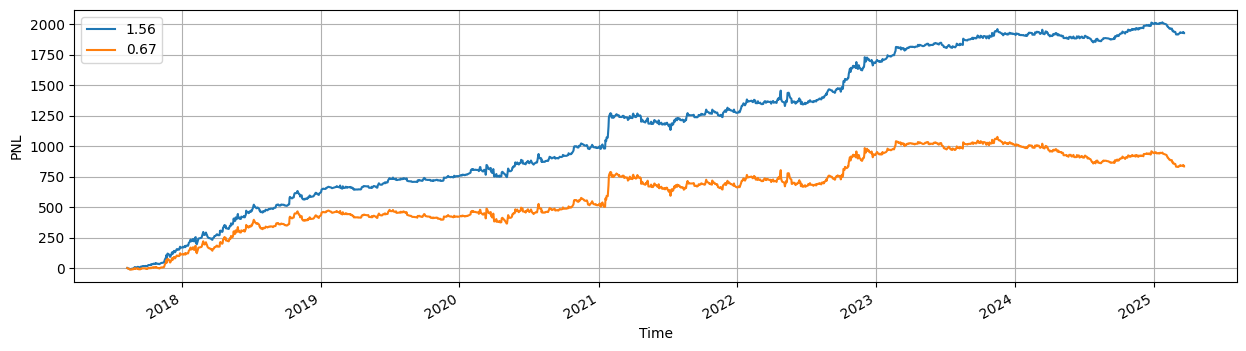

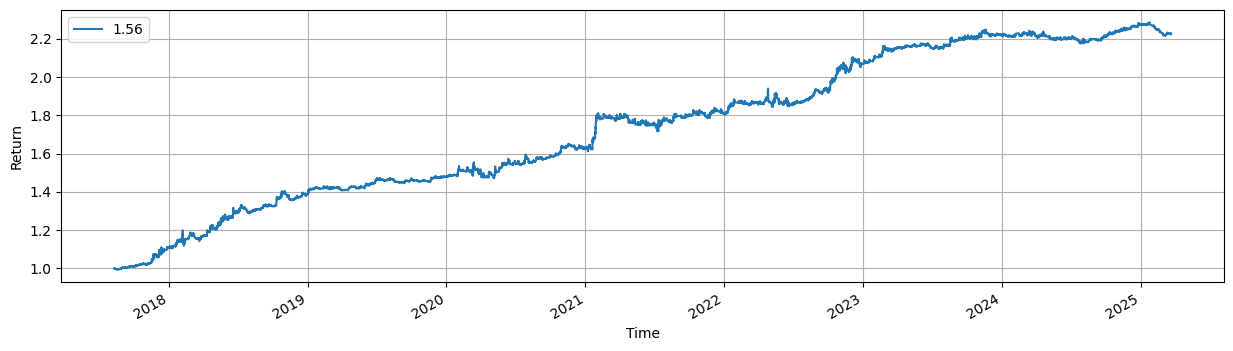

In [ ]:
backtestInfo = BacktestInformation(ds['Date'], ds['pos'], ds['Close'], fee = 0.3) 
pnl = backtestInfo.Plot_PNL()

In [ ]:
ds.pos

Loading ITables v2.5.2 from the internet... (need help?)


In [ ]:
pnl

Loading ITables v2.5.2 from the internet... (need help?)


In [ ]:
merged = pd.merge(ds, pnl, left_on="Date",right_on= "Datetime", how="inner")
merged

Loading ITables v2.5.2 from the internet... (need help?)


In [ ]:
df = pd.DataFrame(ds)

# select Date and pos
df_result = df[["Date", "Close", "pos"]]
df_result

Loading ITables v2.5.2 from the internet... (need help?)


In [ ]:
# df_result.to_csv("alpha2_pos.csv", index=False)